# OCT - VGG - RANDOM

## Installing and Importing Libraries

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG

import tensorflow as tf
from pathlib import Path

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from sklearn.utils import class_weight 

1 Physical GPUs, 1 Logical GPUs


## Importing Dataset and Data Pre-Processing

In [3]:
data_dir = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/OCT/OCT_RANDOM/"
train_data_dir= '/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/OCT/OCT_RANDOM/train/'
test_data_dir= '/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/OCT/OCT_RANDOM/test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32
# image_arr_size= img_width * img_height * channels

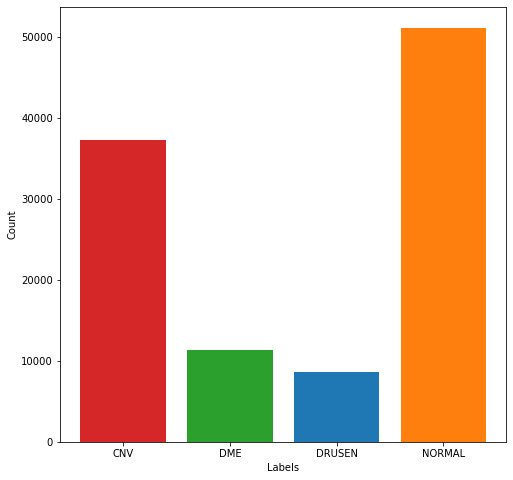

In [4]:
cnv_images = len(glob(train_data_dir + 'CNV/*.jpeg'))
dme_images = len(glob(train_data_dir + 'DME/*.jpeg'))
drusen_images = len(glob(train_data_dir + 'DRUSEM/*.jpeg'))
normal_images = len(glob(train_data_dir + 'NORMAL/*.jpeg'))
data= {'CNV': cnv_images, 'DME': dme_images, 'DRUSEN': drusen_images, 'NORMAL': normal_images}
labels = list(data.keys()) 
count = list(data.values()) 

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

### Image Histogram (Tonal Distribution)
* Histogram of a normal retina image in the train dataset:

### Sample Images from the Dataset

Normal


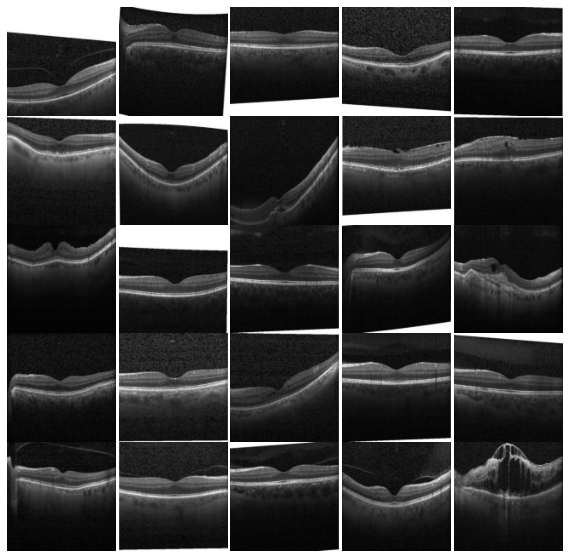

In [5]:
print("Normal")
multipleImages = glob(data_dir + 'train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Choroidal Neo-Vascularization (CNV)


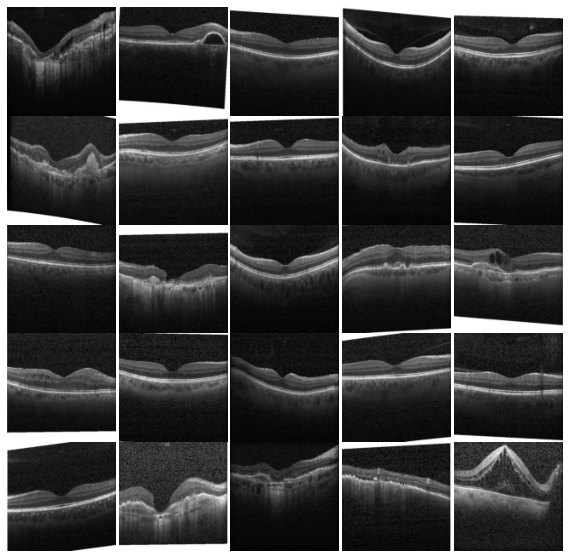

In [6]:
print("Choroidal Neo-Vascularization (CNV)")
multipleImages = glob(data_dir + 'train/CNV/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Diabetic Macular Edema (DME)


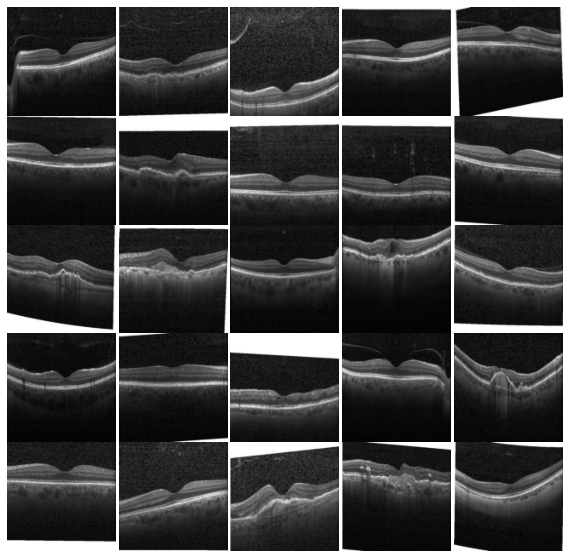

In [7]:
print("Diabetic Macular Edema (DME)") 
multipleImages = glob(data_dir + 'train/DME/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('dme_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Drusen


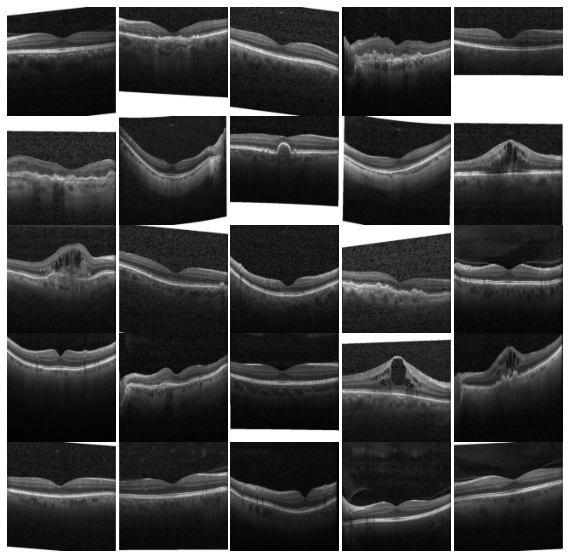

In [8]:
print("Drusen")
multipleImages = glob(data_dir + 'train/DRUSEM/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('drusen_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

### Keras Data Generators

In [9]:
train_datagen = ImageDataGenerator(
)

valid_test_datagen = ImageDataGenerator(
)

In [10]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    batch_size= batch_size,  
    class_mode= 'categorical',
    seed= 1337
) 

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    batch_size= batch_size,        
    class_mode= 'categorical'
)

Found 108309 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [11]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

nb_train_samples = len(train_generator.filenames)  
nb_test_samples = len(test_generator.filenames)

### Model

### VGG16 Architecture

In [11]:
model = VGG16(include_top= True, input_shape= (img_width, img_height, channels), classes=4, weights=None)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

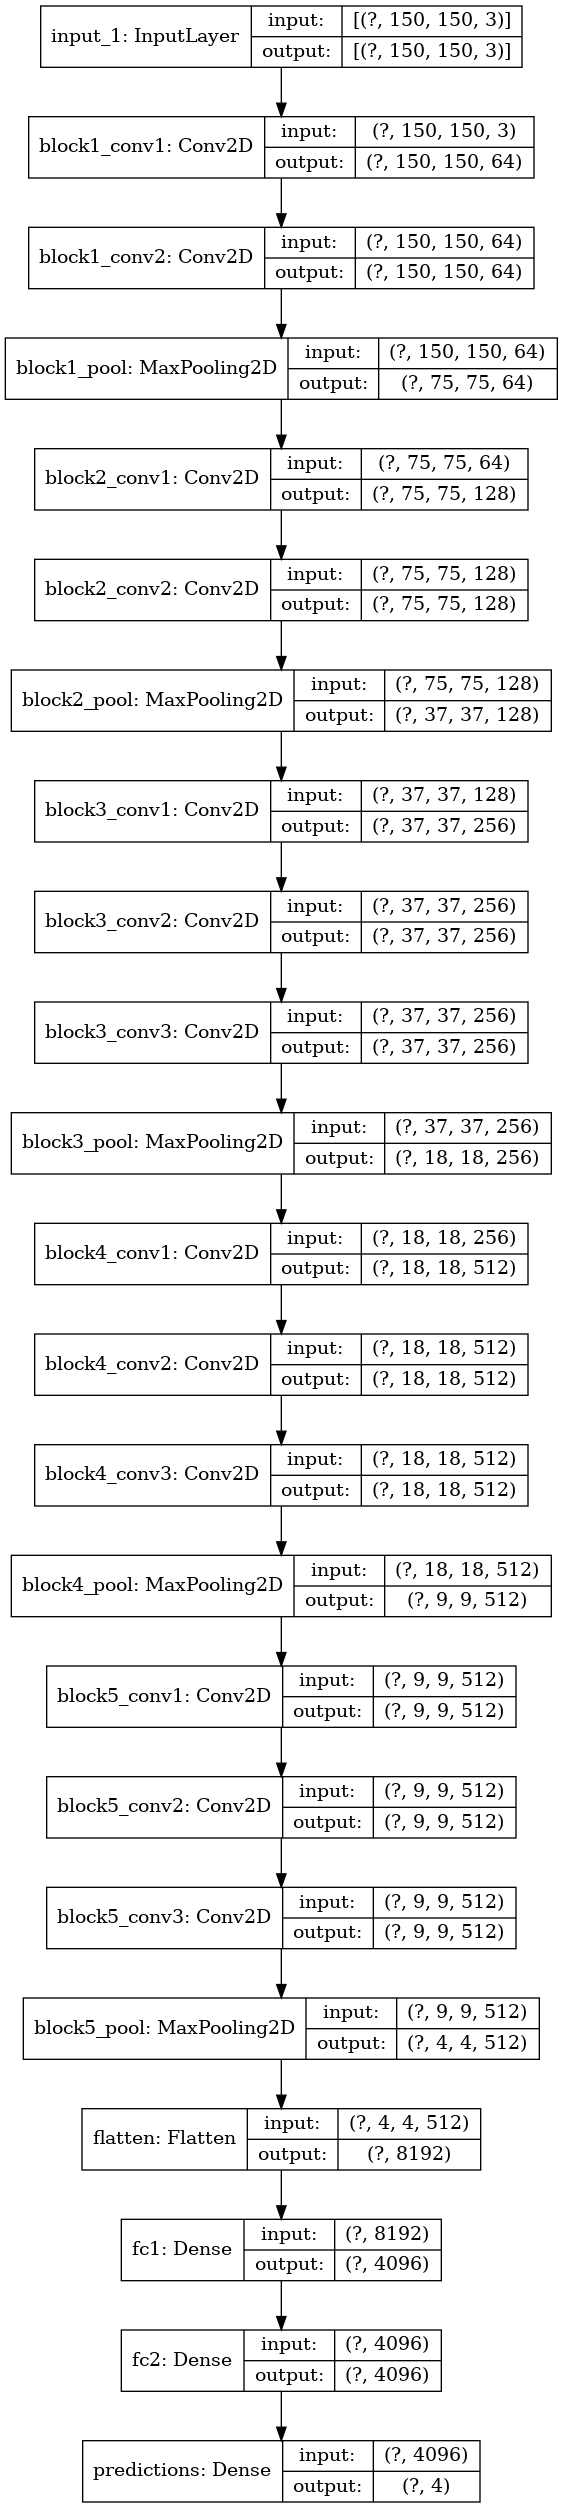

In [12]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

## Model Training MEMORIZING RANDOM

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
checkpoint = ModelCheckpoint(
    'basetuned_model.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)


csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='loss',
    factor=0.75,
    patience=3,
    verbose=1, 
    mode='auto'
)

class_weights = class_weight.compute_class_weight(
       'balanced',
        np.unique(train_generator.classes), 
        train_generator.classes)
class_weights = dict(enumerate(class_weights))

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

/home/maia/anaconda3/envs/MST_TRAIN_CLONE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 3 3 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [ ]:
history = model.fit(
    train_generator,
    epochs = 100,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = test_generator,
    validation_steps = nb_test_samples//batch_size,
    verbose = 1,
    callbacks = callbacks,
    shuffle = True,
    class_weight=class_weights
)

In [12]:
model = load_model("basetuned_model.h5")

In [13]:
history = pd.read_csv("baseline_training_csv.log")

In [17]:
history

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.241150,1.387280,0.252016,2.355898
1,1,0.252685,1.386595,0.229839,2.342135
2,2,0.201862,1.386139,0.244960,2.355786
3,3,0.211910,1.386217,0.236895,2.363041
4,4,0.214422,1.386102,0.224798,2.355467
...,...,...,...,...,...
95,95,0.940117,0.123264,0.266129,9.088665
96,96,0.940625,0.121929,0.254032,8.898317
97,97,0.939978,0.121508,0.256048,8.832997
98,98,0.940227,0.120933,0.278226,8.397751


In [15]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

  ...
    to  
  ['...']
32/32 [==============================] - 7s 217ms/step - loss: 4.1210 - accuracy: 0.2600
Test Loss:  4.120953686535358
Test Accuracy:  0.26


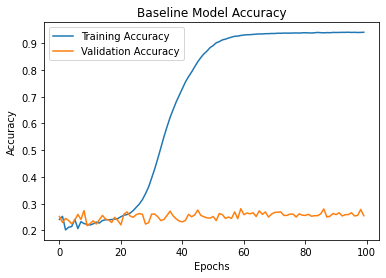

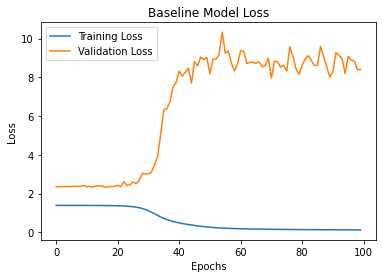

In [18]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

/home/maia/anaconda3/envs/MST_TRAIN_CLONE/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  if __name__ == '__main__':


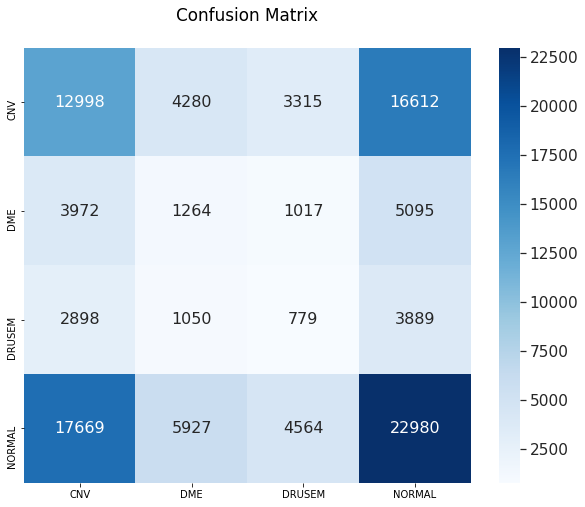

Classification Report

              precision    recall  f1-score   support

         CNV       0.35      0.35      0.35     37205
         DME       0.10      0.11      0.11     11348
      DRUSEM       0.08      0.09      0.09      8616
      NORMAL       0.47      0.45      0.46     51140

    accuracy                           0.35    108309
   macro avg       0.25      0.25      0.25    108309
weighted avg       0.36      0.35      0.35    108309



In [19]:
Y_pred = model.predict(train_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(train_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(train_generator.class_indices.keys()), list(train_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues, fmt="d")
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix_train.png', transparent= False, bbox_inches= 'tight', dpi= 400, fmt="d")
plt.show()

print('Classification Report\n')
target_names = list(train_generator.class_indices.keys())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

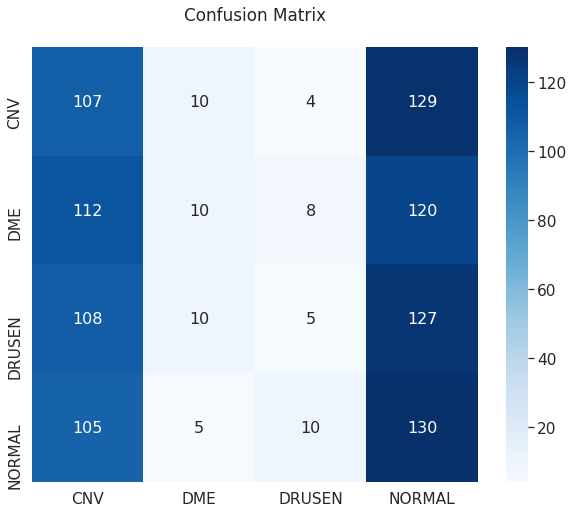

Classification Report

              precision    recall  f1-score   support

         CNV       0.25      0.43      0.31       250
         DME       0.29      0.04      0.07       250
      DRUSEN       0.19      0.02      0.04       250
      NORMAL       0.26      0.52      0.34       250

    accuracy                           0.25      1000
   macro avg       0.24      0.25      0.19      1000
weighted avg       0.24      0.25      0.19      1000



In [20]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues, fmt="d")
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))